Internal H-field
=========================================

*Author: Clément Majorel*  *(internal H-field calculation code by C. Majorel)*


In this example we calculate the internal magnetic field distribution, trying to reproduce the physics reported by *Bakker et al.* [1].

First we load pyGDM, construct the geometry and setup the simulation.


[1]: Bakker, R. M. et al. *Magnetic and Electric Hotspots with Silicon Nanodimers*. Nano Lett. 15, 2137–2142 (2015). (https://pubs.acs.org/doi/abs/10.1021/acs.nanolett.5b00128)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 1162/1162 dipoles valid

 =============== GDM Simulation Information ===============
precision: <class 'numpy.float32'> / <class 'numpy.complex64'>


 ------ nano-object -------
   Homogeneous object. 
   material:             "Silicon, Palik"
   mesh type:            hexagonal compact
   nominal stepsize:     20.0nm
   nr. of meshpoints:    1162

 ----- incident field -----
   field generator: "plane_wave"
   51 wavelengths between 450.0 and 800.0nm
   2 incident field configurations per wavelength

 ------ environment -------
   n3 = constant index material, n=(1+0j)  <-- top
   n2 = constant index material, n=(1+0j)  <-- center layer (height "spacing" = 5000nm)
   n1 = constant index material, n=(1.5+0j)  <-- substrate

 ===== *core.scatter* ======
   NO self-consistent E-fields
   NO self-consistent H-fields


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


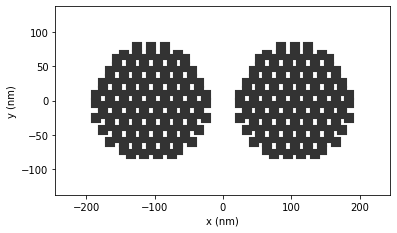

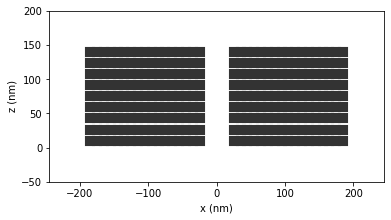

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=450.00nm - setup: EE 5187.5ms, HE 4613.2ms, inv.: 720.5ms, repropa.: 987.8ms (2 field configs), tot: 11527.9ms
timing for wl=457.00nm - setup: EE 2324.4ms, HE 550.6ms, inv.: 78.1ms, repropa.: 371.6ms (2 field configs), tot: 3344.5ms
timing for wl=464.00nm - setup: EE 2298.3ms, HE 552.8ms, inv.: 75.6ms, repropa.: 358.8ms (2 field configs), tot: 3305.8ms
timing for wl=471.00nm - setup: EE 2306.1ms, HE 563.7ms, inv.: 77.3ms, repropa.: 364.7ms (2 field configs), tot: 3332.0ms
timing for wl=478.00nm - setup: EE 2315.3ms, HE 583.7ms, inv.: 77.8ms, repropa.: 374.9ms (2 field configs), tot: 3372.4ms
timing for wl=485.00nm - setup: EE 2246.7ms, HE 583.8ms, inv.: 75.9ms, repropa.: 363.9ms (2 field configs), tot: 3292.0ms
timing for wl=492.00nm - setup: EE 2324.9ms, HE 536.1ms, inv.: 72.9ms, repropa.: 381.7ms (2 field configs), tot: 3335.5ms
timing for wl=499.00nm - setup: EE 2306.8ms, HE 523.3ms, inv.: 73.6ms, repropa.: 364.8ms (2 field configs), tot: 3288.2ms
timing for wl=506.00n

1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import visu
from pyGDM2 import tools
from pyGDM2 import linear



## --------------- Setup
mesh = 'hex'
step = 20.0

R_nm = 90.
H_nm = 160
R = R_nm//step
H = H_nm//step
GAP = 30.

## geometry    
geo2 = structures.nanodisc(step, R, H, mesh=mesh)
geo2 = structures.center_struct(geo2)
geo2.T[0] += R_nm+GAP/2.

geo1 = structures.nanodisc(step, R, H, mesh=mesh)
geo1 = structures.center_struct(geo1)
geo1.T[0] -= R_nm+GAP/2.

geo = structures.combine_geometries((geo1, geo2), step)


mat = materials.silicon()
struct = structures.struct(step, geo, mat)


## incident field
wavelengths = np.linspace(450,800, 51)
field_generator = fields.plane_wave
kwargs = dict(theta=[0, 90.], inc_angle=0)     # bottom incidence

efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## environment: air over glass substrate
dyads = propagators.DyadsQuasistatic123(n1=1.5, n2=1)


## simulation initialization
sim = core.simulation(struct, efield, dyads)
print(sim)

visu.structure(sim)
visu.structure(sim, projection='xz')


## --------------- run scatter simulation
sim.scatter(calc_H=True, verbose=True)

Plot spectra and field-amplitudes at resonance
--------------------------------

Note that the internal magnetic field simulation is done by passing the `calc_H=True` kwarg to `scatter`.

Now we plot the extinction spectra, as well as the absolute field amplitude of E and H-field inside and around the nano-disc dimer.

We reproduce well the results from Bakker et al. 


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/linear.py:216: UserWarning: Multipole decomposition is a new functionality still under testing. Please use with caution.
  warnings.warn("Multipole decomposition is a new functionality still under testing. " +
/home/hans/.local/lib/python3.8/site-packages/pyGDM2/linear.py:216: UserWarning: Multipole decomposition is a new functionality still under testing. Please use with caution.
  warnings.warn("Multipole decomposition is a new functionality still under testing. " +


4 4
4 4
4 4
4 4
4 4
4 4
4 4
4 4


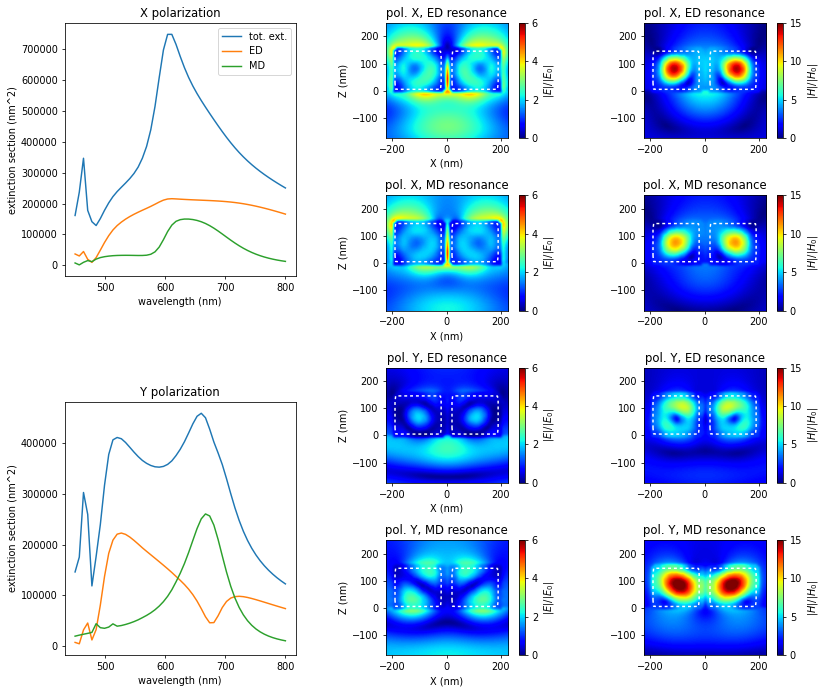

In [2]:
field_configs = [
    dict(theta=0, wavelength=611),
    dict(theta=0, wavelength=632),
    dict(theta=90, wavelength=527),
    dict(theta=90, wavelength=667)
    ]
title_list = [
    'pol. X, ED resonance',
    'pol. X, MD resonance',
    'pol. Y, ED resonance',
    'pol. Y, MD resonance',
    ]

r_probe = tools.generate_NF_map_XZ(-225, 225, 51,   -175, 250, 51,     0)

plt.figure(figsize=(12,10), dpi=70)


## --- plot spectra
wl, extsp = tools.calculate_spectrum(sim, 0, linear.extinct)
ex, sc, ab = extsp.T
wl, extmp = tools.calculate_spectrum(sim, 0, linear.multipole_decomp_extinct)
p, m = extmp.T

plt.subplot(231)
plt.title("X polarization")
plt.plot(wl, ex, label='tot. ext.')
plt.plot(wl, np.abs(p), label='ED')
plt.plot(wl, np.abs(m), label='MD')
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction section (nm^2)")
plt.legend()


wl, extsp = tools.calculate_spectrum(sim, 1, linear.extinct)
ex, sc, ab = extsp.T
wl, extmp = tools.calculate_spectrum(sim, 1, linear.multipole_decomp_extinct)
p, m = extmp.T

plt.subplot(234)
plt.title("Y polarization")
plt.plot(wl, ex)
plt.plot(wl, np.abs(p))
plt.plot(wl, np.abs(m))
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction section (nm^2)")


## --- plot field-amplitude maps
for i_plot, field_conf in enumerate(field_configs):
    fidx = tools.get_closest_field_index(sim, field_conf)
    Es,Et, Bs,Bt = linear.nearfield(sim, fidx, r_probe)
    
    
    # plt.suptitle(title_list[i_plot])
    plt.subplot(4,3,3*i_plot+2)
    plt.title(title_list[i_plot])
    im = visu.vectorfield_color(Et, show=0, projection='XZ', fieldComp='abs', interpolation='bicubic', cmap='jet')
    plt.colorbar(im, label='$|E|/|E_0|$')
    im.set_clim(0,6)
    visu.structure_contour(sim, projection='XZ', color='w', show=0, dashes=[2,2], lw=1.5, zorder=10)
    plt.xlabel('X (nm)'); plt.ylabel('Z (nm)')
    
    plt.subplot(4,3,3*i_plot+3)
    plt.title(title_list[i_plot])
    im = visu.vectorfield_color(Bt, show=0, projection='XZ', fieldComp='abs', interpolation='bicubic', cmap='jet')
    plt.colorbar(im, label='$|H|/|H_0|$')
    im.set_clim(0,15)
    visu.structure_contour(sim, projection='XZ', color='w', show=0, dashes=[2,2], lw=1.5, zorder=10)
    
plt.tight_layout()
plt.show()